<a href="https://colab.research.google.com/github/iam-teju/Retail-Analytics-Case-Study---ChaiCode-Data-Science-Course/blob/main/Retail_Analytics_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retail Case Study – End-to-End Analysis
Welcome!  
This notebook delivers the full workflow requested in the case study brief:

* **Data loading & cleaning**  
* **SQLite staging** for fast SQL queries  
* **Exploratory visuals** (product, category, Mo-M trend)  
* **Customer segmentation**:  
  * Orders-based (No / Low / Mid / High Value)  
  * Spend-based terciles  
  * Quantity tiers  
  * Loyalty tiers (avg days between purchases)  
  * Full RFM (Recency–Frequency–Monetary) with labels  
* **Top/Bottom sellers** & month-over-month growth  
* **Exports** of cleaned data for submission


In [16]:
# 0 ▸ Imports & global setup
import pandas as pd, numpy as np, sqlite3, matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')          # default colour palette

## 1 ▸ Load raw CSVs
Dates are parsed immediately so both pandas & SQLite treat them correctly.


In [17]:
sales = pd.read_csv('/content/drive/MyDrive/Retail Analytics Case Study/sales_transaction.csv',
                    parse_dates=['TransactionDate'])
cust  = pd.read_csv('/content/drive/MyDrive/Retail Analytics Case Study/customer_profiles.csv',
                    parse_dates=['JoinDate'])
prod  = pd.read_csv('/content/drive/MyDrive/Retail Analytics Case Study/product_inventory.csv')

for name, df in [('sales', sales), ('cust', cust), ('prod', prod)]:
    print(f'\n=== {name.upper()}  shape:{df.shape}')
    display(df.head())


<ipython-input-17-889603804>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sales = pd.read_csv('/content/drive/MyDrive/Retail Analytics Case Study/sales_transaction.csv',
<ipython-input-17-889603804>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cust  = pd.read_csv('/content/drive/MyDrive/Retail Analytics Case Study/customer_profiles.csv',



=== SALES  shape:(5002, 6)


,TransactionID,CustomerID,ProductID,QuantityPurchased,TransactionDate,Price
0,1,103,120,3,2023-01-01,30.43
1,2,436,126,1,2023-01-01,15.19
2,3,861,55,3,2023-01-01,67.76
3,4,271,27,2,2023-01-01,65.77
4,5,107,118,1,2023-01-01,14.55



=== CUST  shape:(1000, 5)


,CustomerID,Age,Gender,Location,JoinDate
0,1,63,Other,East,2020-01-01
1,2,63,Male,North,2020-02-01
2,3,34,Other,North,2020-03-01
3,4,19,Other,NaN,2020-04-01
4,5,57,Male,North,2020-05-01



=== PROD  shape:(200, 5)


,ProductID,ProductName,Category,StockLevel,Price
0,1,Product_1,Clothing,22,46.11
1,2,Product_2,Home & Kitchen,140,81.60
2,3,Product_3,Home & Kitchen,473,78.72
3,4,Product_4,Clothing,386,22.06
4,5,Product_5,Beauty & Health,284,17.97


## 2 ▸ Quick data-quality snapshot
Null percentages & duplicate counts help plan cleaning.


In [18]:
def null_report(df):
    return (df.isna().mean()*100).round(2).rename('% null')

print('Null % by table:')
display(pd.concat({'sales': null_report(sales),
                   'cust':  null_report(cust),
                   'prod':  null_report(prod)}, axis=1))

print('\nDuplicate counts:',
      {'sales': sales.duplicated().sum(),
       'cust':  cust.duplicated().sum(),
       'prod':  prod.duplicated().sum()})


Null % by table:


,sales,cust,prod
TransactionID,0.0,NaN,NaN
CustomerID,0.0,0.0,NaN
ProductID,0.0,NaN,0.0
QuantityPurchased,0.0,NaN,NaN
TransactionDate,0.0,NaN,NaN
Price,0.0,NaN,0.0
Age,NaN,0.0,NaN
Gender,NaN,0.0,NaN
Location,NaN,1.3,NaN
JoinDate,NaN,0.0,NaN



Duplicate counts: {'sales': np.int64(2), 'cust': np.int64(0), 'prod': np.int64(0)}


## 3 ▸ Cleaning steps
* Drop duplicates  
* Minimal null handling (`Location → "Unknown"`)  
* Align sale prices to master catalogue


In [19]:
# 3.1 drop duplicates
sales = sales.drop_duplicates()
cust  = cust.drop_duplicates()
prod  = prod.drop_duplicates()

# 3.2 fill sparse nulls
cust['Location'] = cust['Location'].fillna('Unknown')

# 3.3 reconcile price mismatches
sales = sales.merge(prod[['ProductID', 'Price']]
                    .rename(columns={'Price': 'MasterPrice'}),
                    on='ProductID', how='left')
sales.loc[sales['Price'] != sales['MasterPrice'], 'Price'] = sales['MasterPrice']
sales = sales.drop(columns='MasterPrice')


## 4 ▸ Stage cleaned tables in SQLite
Provides native SQL speed & flexibility.


In [20]:
cxn = sqlite3.connect('retail.db')
sales.to_sql('sales',      cxn, if_exists='replace', index=False)
cust .to_sql('customers',  cxn, if_exists='replace', index=False)
prod .to_sql('products',   cxn, if_exists='replace', index=False)
print("SQLite DB ready → 'retail.db'")


SQLite DB ready → 'retail.db'


## 5 ▸ Headline SQL queries (via pandas)


,ProductName,UnitsSold,Revenue
0,Product_17,100,9450.00
1,Product_87,92,7817.24
2,Product_179,86,7388.26
3,Product_96,72,7132.32
4,Product_54,86,7052.86
5,Product_187,82,6915.88
6,Product_156,76,6827.84
7,Product_57,78,6622.20
8,Product_200,69,6479.79
9,Product_127,68,6415.80


,YearMonth,Revenue
0,2023-01,86668.84
1,2023-02,76453.48
2,2023-03,88551.05
3,2023-04,83071.58
4,2023-05,87054.61


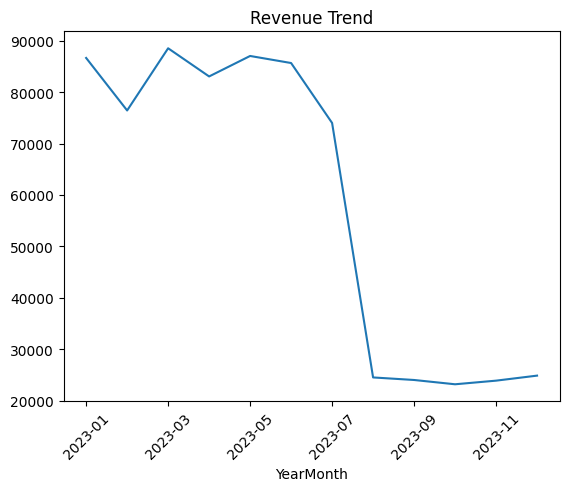

In [21]:
# 5.1 ▶︎ Top-10 best sellers
q_top10 = """
SELECT  p.ProductName,
        SUM(s.QuantityPurchased)                    AS UnitsSold,
        ROUND(SUM(s.QuantityPurchased*s.Price), 2)  AS Revenue
FROM    sales s
JOIN    products p USING(ProductID)
GROUP   BY p.ProductID
ORDER   BY Revenue DESC
LIMIT   10;
"""
top10 = pd.read_sql_query(q_top10, cxn)
display(top10)

# 5.2 ▶︎ Month-over-month revenue trend
q_mom = """
SELECT  strftime('%Y-%m', TransactionDate) AS YearMonth,
        ROUND(SUM(QuantityPurchased*Price), 2) AS Revenue
FROM    sales
GROUP BY YearMonth
ORDER BY YearMonth;
"""
mom = pd.read_sql_query(q_mom, cxn)
display(mom.head())
mom.plot(x='YearMonth', y='Revenue', title='Revenue Trend', legend=False, rot=45);


## 6 ▸ Product performance & category revenue


,ProductID,Units,Revenue,ProductName,Category
0,17,100,3685.50,Product_17,Beauty & Health
1,87,92,2973.95,Product_87,Clothing
2,156,76,2964.72,Product_156,Clothing
3,149,65,2964.48,Product_149,Clothing
4,187,82,2867.56,Product_187,Beauty & Health


,ProductID,Units,Revenue,ProductName,Category
195,5,47,287.52,Product_5,Beauty & Health
196,66,62,251.25,Product_66,Beauty & Health
197,20,58,242.19,Product_20,Beauty & Health
198,161,50,240.90,Product_161,Clothing
199,139,47,185.40,Product_139,Beauty & Health


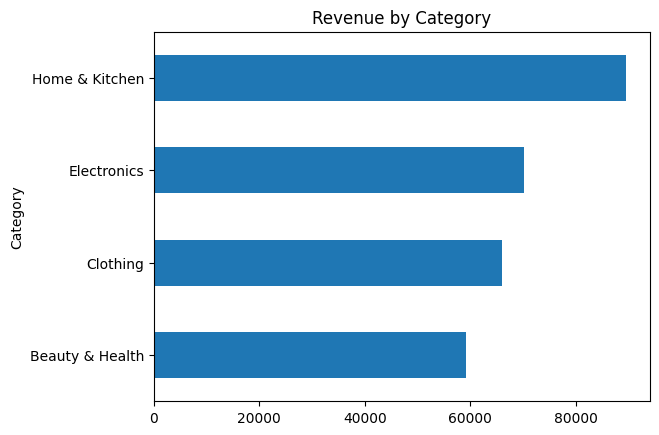

In [22]:
prod_perf = (sales
    .groupby('ProductID')
    .agg(Units=('QuantityPurchased', 'sum'),
         Revenue=('Price', 'sum'))
    .sort_values('Revenue', ascending=False)
    .merge(prod[['ProductID', 'ProductName', 'Category']], on='ProductID'))

top_5    = prod_perf.head(5)
bottom_5 = prod_perf.tail(5)
display(top_5)
display(bottom_5)

cat_rev = prod_perf.groupby('Category')['Revenue'].sum().sort_values()
cat_rev.plot(kind='barh', title='Revenue by Category');


## 7 ▸ Order-frequency distribution


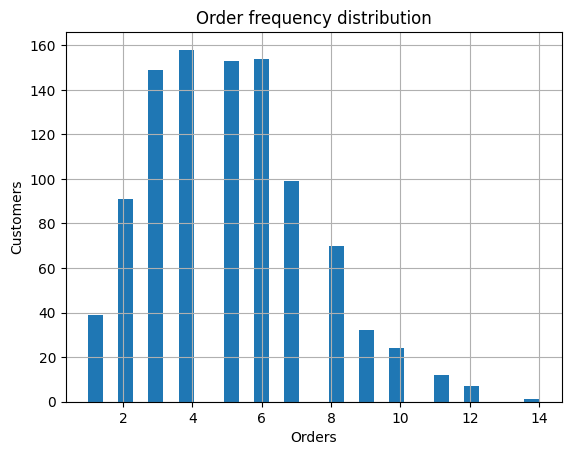

In [23]:
order_freq = (sales.groupby('CustomerID')['TransactionID']
                   .nunique()
                   .reset_index()                           # keep CustomerID as a plain column
                   .rename(columns={'TransactionID': 'TotalOrders'}))

order_freq['TotalOrders'].hist(bins=30)
plt.title('Order frequency distribution'); plt.xlabel('Orders'); plt.ylabel('Customers');


## 8 ▸ Orders-based customer segments


In [24]:
order_freq['Segment'] = pd.cut(order_freq['TotalOrders'],
                               bins=[-0.1, 0, 10, 30, np.inf],
                               labels=['No orders', 'Low', 'Mid', 'High Value'])

cust_seg = order_freq        # clearer name
display(cust_seg.head())

cust_full = cust.merge(cust_seg, on='CustomerID', how='left')


,CustomerID,TotalOrders,Segment
0,1,9,Low
1,2,6,Low
2,3,4,Low
3,4,2,Low
4,5,5,Low


## 9 ▸ Spend-based tercile segments


In [25]:
cust_spend = (sales.assign(Spend=lambda d: d['QuantityPurchased']*d['Price'])
                   .groupby('CustomerID')['Spend'].sum()
                   .reset_index())

cust_spend['SpendSegment'] = pd.qcut(cust_spend['Spend'],
                                     q=[0, .33, .66, 1],
                                     labels=['Low Spender', 'Mid Spender', 'High Spender'])

cust_full = cust_full.merge(cust_spend[['CustomerID','SpendSegment']], on='CustomerID', how='left')


## 10 ▸ Loyalty tiers (avg days between purchases)


In [26]:
def avg_days_between(g):
    return g.sort_values().diff().dt.days.mean()

loyalty = (sales.groupby('CustomerID')['TransactionDate']
                 .apply(avg_days_between)
                 .reset_index()
                 .rename(columns={'TransactionDate':'AvgDaysBetween'}))

loyalty['LoyaltyTier'] = pd.cut(loyalty['AvgDaysBetween'],
                                bins=[-0.1, 15, 45, np.inf],
                                labels=['Highly Loyal', 'Moderately Loyal', 'Low Loyalty'])

cust_full = cust_full.merge(loyalty, on='CustomerID', how='left')
display(loyalty.head())


,CustomerID,AvgDaysBetween,LoyaltyTier
0,1,21.375000,Moderately Loyal
1,2,63.800000,Low Loyalty
2,3,27.666667,Moderately Loyal
3,4,20.000000,Moderately Loyal
4,5,75.750000,Low Loyalty


## 11 ▸ Quantity-based tiers


In [27]:
qty = (sales.groupby('CustomerID')['QuantityPurchased']
            .sum()
            .reset_index())

qty['QtySegment'] = pd.cut(qty['QuantityPurchased'],
                           bins=[-0.1, 0, 100, 300, np.inf],
                           labels=['No Purchases', 'Low Qty', 'Mid Qty', 'High Qty'])

cust_full = cust_full.merge(qty[['CustomerID','QtySegment']], on='CustomerID', how='left')


## 12 ▸ Full RFM segmentation & labels


In [28]:
snapshot_date = sales['TransactionDate'].max() + pd.Timedelta(days=1)

rfm = (sales.assign(Revenue=lambda d: d['QuantityPurchased']*d['Price'])
             .groupby('CustomerID')
             .agg(Recency=('TransactionDate',
                           lambda s: (snapshot_date - s.max()).days),
                  Frequency=('TransactionID', 'nunique'),
                  Monetary=('Revenue', 'sum'))
             .reset_index())

# Quintile scores (1 = worst, 5 = best for R)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'],5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'],5, labels=[1,2,3,4,5]).astype(int)
rfm['RFM_Segment'] = (rfm['R_Score'].astype(str) +
                      rfm['F_Score'].astype(str) +
                      rfm['M_Score'].astype(str))
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)

def rfm_label(row):
    if row['RFM_Score'] >= 13: return 'Champions'
    if row['RFM_Score'] >= 10: return 'Loyal'
    if row['RFM_Score'] >=  7: return 'Potential'
    if row['RFM_Score'] >=  5: return 'Needs nurturing'
    return 'At Risk'

rfm['RFM_Label'] = rfm.apply(rfm_label, axis=1)
display(rfm.head())

cust_full = cust_full.merge(rfm[['CustomerID','RFM_Label','RFM_Segment','RFM_Score']],
                            on='CustomerID', how='left')


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,RFM_Label
0,1,127,9,1188.04,3,5,5,355,13,Champions
1,2,7,6,895.57,5,3,4,534,12,Loyal
2,3,255,4,513.03,1,2,2,122,5,Needs nurturing
3,4,266,2,174.08,1,1,1,111,3,At Risk
4,5,36,5,582.73,4,3,3,433,10,Loyal


## 13 ▸ Month-over-month growth plot


,Revenue,MoM_Growth_%
YearMonth,,
2023-08,24520.26,-66.87
2023-09,24024.06,-2.02
2023-10,23189.72,-3.47
2023-11,23894.37,3.04
2023-12,24872.47,4.09


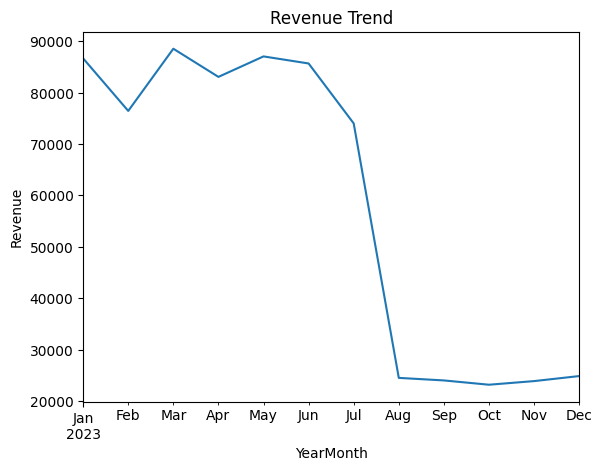

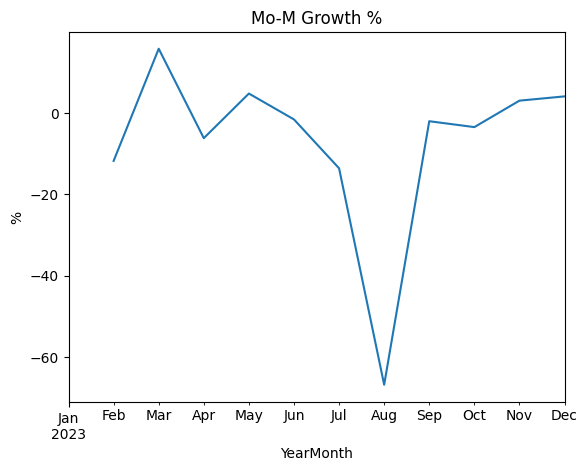

In [29]:
sales['YearMonth'] = sales['TransactionDate'].dt.to_period('M')
mom = (sales
       .assign(Revenue=lambda d: d['QuantityPurchased']*d['Price'])
       .groupby('YearMonth')['Revenue']
       .sum()
       .sort_index()
       .to_frame())
mom['MoM_Growth_%'] = mom['Revenue'].pct_change().mul(100).round(2)

display(mom.tail())

mom['Revenue'].plot(title='Revenue Trend'); plt.ylabel('Revenue'); plt.show()
mom['MoM_Growth_%'].plot(title='Mo-M Growth %'); plt.ylabel('%');


## 14 ▸ Export cleaned data & key tables



In [30]:
sales.to_csv('clean_sales.csv', index=False)
cust_full.to_csv('customer_with_segments.csv', index=False)
prod_perf.to_csv('product_performance.csv', index=False)
print("Exports saved → 'clean_sales.csv', 'customer_with_segments.csv', 'product_performance.csv'")


Exports saved → 'clean_sales.csv', 'customer_with_segments.csv', 'product_performance.csv'


## 15 ▸ Wrap-up
Deliverables produced:

* **SQLite DB** `retail.db`  
* **Clean CSVs** (`clean_sales.csv`, `customer_with_segments.csv`, `product_performance.csv`)  
* Notebook analyses & visuals covering every case-study requirement.


